In [1]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(1)

import time
from datetime import datetime

from collections import defaultdict
from collections import Counter

from random import randint
import pickle

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('error')

import string
# puncs = set(string.punctuation)

In [2]:
portion = 29000

#training sets
with open('tokenized_low.BPE.en') as f:
    train_en = [l.strip() for l in f.readlines()][:portion]
with open('tokenized_low.BPE.fr') as f:
    train_fr = [l.strip() for l in f.readlines()][:portion]

# #validation sets
# with open('val.en') as f:
#     val_en = [l.strip() for l in f.readlines()]
# with open('val.fr') as f:
#     val_fr = [l.strip() for l in f.readlines()]

# #test sets
# with open('test_tokenized.BPE.en') as f:
#     test_en = [l.strip() for l in f.readlines()]
# with open('test_tokenized.BPE.fr') as f:
#     test_fr = [l.strip() for l in f.readlines()]

In [3]:
#TODO
# 0 PAD - padding 0 for convenience in masking?
# 1 BOS - beginning of sentence
# 2 EOS - end of sentence
# 3 UNK - unknown

In [4]:
max_sentence_length = 50

In [5]:
def tokens_sentences(sentences):
    tokens_list = []
    sentence_list = []
    for s in sentences:
        split_sent = s.split()
        sentence = []
        for w in split_sent:
#             if w not in puncs:
            tokens_list.append(w)
            sentence.append(w)

        sentence_list.append(sentence)
    
    return tokens_list, sentence_list

In [6]:
tokens_list,sentence_list = tokens_sentences(train_en)

print(tokens_list[4])
print(sentence_list[0][4])

print(len(tokens_list))
print(len(sorted(set(tokens_list))))
# print(set(tokens_list))

m@@
m@@
563773
812


In [7]:
tokens_list_en, sentence_list_en = tokens_sentences(train_en)

tokens_train_en = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_en.extend(list(sorted(set(tokens_list_en))))
vocab_size_en = len(tokens_train_en)
print('Vocabulary size EN', vocab_size_en)

count_tokens_train_en = Counter(tokens_list_en)

tokens_list_fr, sentence_list_fr = tokens_sentences(train_fr)

tokens_train_fr = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_fr.extend(list(sorted(set(tokens_list_fr))))
vocab_size_fr = len(tokens_train_fr)
print('Vocabulary size FR', len(tokens_train_fr))

count_tokens_train_fr = Counter(tokens_list_fr)

Vocabulary size EN 816
Vocabulary size FR 862


In [8]:
def get_id_dicts(tokens):
    #default dictionary key:id value:token
    id2tokens = defaultdict(str)

    for i in range(len(tokens)):
        id2tokens[i] = tokens[i]

    #default dictionary key:token value:id
    tokens2id = defaultdict(int)

    for ind in id2tokens:
        tokens2id[id2tokens[ind]] = ind

    return tokens2id, id2tokens

In [9]:
tokens2id_en, id2tokens_en = get_id_dicts(tokens_train_en)

vocabulary_size_train_en = len(tokens2id_en)
print(vocabulary_size_train_en)

tokens2id_fr, id2tokens_fr = get_id_dicts(tokens_train_fr)

vocabulary_size_train_fr = len(tokens2id_fr)
print(vocabulary_size_train_fr)

# print(tokens2id_en['m@@'])
# print(id2tokens_en[1])

816
862


In [10]:
#building the corpora (list of list of ids) simultaneously 
def convert_corpora2id_both(sentence_list_en, sentence_list_fr, tokens2id_en, tokens2id_fr, max_sentence_length):
    
    #counts to check long sentences
    counter_long = 0
    
    #convert dataset to ids
    corpus2id_en = []
    corpus2id_fr = []
    
    for s in range(len(sentence_list_en)):
    
        sentence2id_en = []
        sentence2id_en.append(tokens2id_en['<SOS>'])
        
        sentence2id_fr = []
        sentence2id_fr.append(tokens2id_fr['<SOS>'])
        
        sentence_en = sentence_list_en[s]
        sentence_fr = sentence_list_fr[s]
        
        
        for w_en in sentence_en:
            word_id = tokens2id_en[w_en]
            sentence2id_en.append(word_id)
            
        for w_fr in sentence_fr:
            word_id = tokens2id_fr[w_fr]
            sentence2id_fr.append(word_id)
        
        
        sentence2id_en.append(tokens2id_en['<EOS>'])
        sentence2id_fr.append(tokens2id_fr['<EOS>'])

        if len(sentence2id_en) < max_sentence_length and len(sentence2id_fr) < max_sentence_length:
            corpus2id_en.append(sentence2id_en)
            corpus2id_fr.append(sentence2id_fr)
        
        else:
            counter_long += 1
#             print(sentence_list_en[s])
#             print(sentence_list_fr[s])
        
    print('the number of sentences that were not added is',counter_long)       
    return corpus2id_en, corpus2id_fr

In [11]:
# corpus2id_en = convert_corpus2id(sentence_list_en, tokens2id_en, max_sentence_length)
# corpus2id_fr = convert_corpus2id(sentence_list_fr, tokens2id_fr, max_sentence_length)

corpus2id_en, corpus2id_fr = convert_corpora2id_both(sentence_list_en,sentence_list_fr, tokens2id_en, tokens2id_fr, max_sentence_length)

the number of sentences that were not added is 531


In [12]:
# print(corpus2id_en[0])

print('there are ', len(corpus2id_fr), 'french sentences')
print('there are ', len(corpus2id_en), 'english sentences')

there are  28469 french sentences
there are  28469 english sentences


In [13]:
# #get test sentences 

# test_tokens_list_en,test_sentence_list_en = tokens_sentences(test_en)
# test_tokens_list_fr,test_sentence_list_fr = tokens_sentences(test_fr)

# for sent in range(len(test_sentence_list_en)):
#     if len(test_sentence_list_en[sent]) > 50 or len(test_sentence_list_fr[sent]) > 50:
#         print(test_sentence_list_en[sent])
#         print(test_sentence_list_fr[sent])

# test_corpus2id_en, test_corpus2id_fr = convert_corpora2id_both(test_sentence_list_en,test_sentence_list_fr, tokens2id_en, tokens2id_fr, max_sentence_length)




In [14]:
class NMTModel(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, vocab_size_en, dropout_prob):
        super(NMTModel, self).__init__()
        
        self.encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length)
        self.decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)
            
    def forward(self, sent_fr, pos_fr, sent_en, train):
        
        average_context, stacked_contexts = self.encoder(sent_fr, pos_fr)
        
        pred, attention_weights = self.decoder(sent_en, average_context, stacked_contexts, train)
          
        return pred, attention_weights


In [59]:

class Encoder(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length):
        super(Encoder, self).__init__()
        
        self.vocab_size_fr = vocab_size_fr
        self.max_sentence_length = max_sentence_length
        
        self.w_embedding_dim = w_embedding_dim
        self.p_embedding_dim = p_embedding_dim
        
        initrange = 0.5 / self.w_embedding_dim
        self.dec_embedding_dim = dec_embedding_dim
        
        #encoder
        self.w_embeddings = nn.Embedding(self.vocab_size_fr, self.w_embedding_dim)
        self.p_embeddings = nn.Embedding(self.max_sentence_length, self.p_embedding_dim)
        
        self.w_embeddings.weight.data.uniform_(-initrange, initrange)
        self.p_embeddings.weight.data.uniform_(-initrange, initrange)
        
        
        self.context_emb_dim = self.w_embedding_dim + self.p_embedding_dim
        
        #self.context_projection = nn.Linear(self.context_emb_dim, self.dec_embedding_dim)
        #do we use non-linearity after attention
        
        #TODO: DROPOUT
        
        
    def forward(self, sent_fr, pos_fr):
        
        #embedded = self.embedding(input).view(1, 1, -1)
        #TODO:BATCH
       
        ws = self.w_embeddings(sent_fr)
        ps = self.p_embeddings(pos_fr)
        es = torch.cat((ws, ps), 1)
    
        stacked_contexts = es
        average_context = torch.mean(stacked_contexts, dim = 0)
            
        return average_context, stacked_contexts

class Decoder(nn.Module):
    def __init__(self, dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob):
        super(Decoder, self).__init__()
        
        self.vocab_size_en = vocab_size_en
        self.max_sentence_length = max_sentence_length
        
        self.dec_embedding_dim = dec_embedding_dim*2
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        initrange = 0.5 / self.dec_embedding_dim
        self.embedding = nn.Embedding(self.vocab_size_en, self.dec_embedding_dim)
        
        self.embedding.weight.data.uniform_(-initrange, initrange)        
        
        self.lstm = nn.LSTM(self.dec_embedding_dim, self.dec_embedding_dim)
        #self.bidirLSTM = nn.LSTM(self.embedding_dim, self.embedding_dim, bidirectional=True)
        #TODO: LSTM, GRU 
       
        self.pre_rnn_affine = nn.Linear(self.dec_embedding_dim*2, self.dec_embedding_dim)
        #a linear layer after this before softmax
        self.out_affine = nn.Linear(self.dec_embedding_dim, self.vocab_size_en)
               
    
    def forward(self, gold_target_sent, encoder_avg_context, encoder_stacked_contexts, train):
        
        if train:
            pred = []
            attentions = []

            embeds = self.embedding(gold_target_sent)
            embeds = self.dropout(embeds)

            output, (hidden, cell) = self.lstm(embeds.view(-1,1,200),(encoder_avg_context.view(1, 1, -1), torch.zeros(encoder_avg_context.view(1,1,-1).shape)))

            for w in range(len(gold_target_sent)):

                sw = output[w]
                cj = F.softmax(torch.matmul(sw,torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)

                c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()

                sw = torch.cat((sw, c_vec),dim=0)

                s_output = self.out_affine(sw)
                s_output = F.log_softmax(s_output, dim=1)

                pred.append(s_output)

            pred = torch.stack(pred, dim=1)

            return pred, attentions
        
        else:
           
            embeds = self.embedding(gold_target_sent)
            embeds = self.dropout(embeds)

            output, (hidden, cell) = self.lstm(embeds.view(-1,1,200),(encoder_avg_context.view(1, 1, -1), torch.zeros(encoder_avg_context.view(1,1,-1).shape)))

            for w in range(len(gold_target_sent)):

                sw = output[w]
                cj = F.softmax(torch.matmul(sw,torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)

                c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()

                sw = torch.cat((sw, c_vec),dim=0)

                s_output = self.out_affine(sw)
                s_output = F.log_softmax(s_output, dim=1)

                pred.append(s_output)

            pred = torch.stack(pred, dim=1)

            return decoder, attentions
        
        
            decoder_outputs = []
            decoder_attentions = []
        
            test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
            
            test_word_id = tokens2id_en['<SOS>']
            
            for w in range(self.max_sentence_length):
       
                if test_word_id == tokens2id_en['<EOS>']:
                    
                    break  
                    
                output = self.embedding(test_word)
            
                if w == 0:
                    
                    weighted_context = torch.zeros(output.shape)
                    output = torch.cat((output.squeeze(), weighted_context.squeeze()), 0)
                    
                    output = F.relu(self.pre_rnn_affine(output))
                    #TODO: start with 0 vector as h0

                    output, hidden = self.rnn(output.view(1, 1, -1), encoder_avg_context.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])
                    s_output = F.log_softmax(s_output, dim=1) 

                    test_word_id = int(torch.argmax(s_output))
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
           
                    
                else:   
                    #start with weighted context
                    
                    output = torch.cat((output.squeeze(), weighted_context.squeeze()), 0)

                    output = F.relu(self.pre_rnn_affine(output))

                    output, hidden = self.rnn(output.view(1, 1, -1), prev_hidden.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])

                    s_output = F.log_softmax(s_output, dim=1)
                    
                    test_word_id = int(torch.argmax(s_output))
                    
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
                    
                
                attention_weights_word = F.log_softmax(torch.matmul(encoder_stacked_contexts, prev_hidden.view(-1,1)), dim = 0)

                weighted_context = torch.sum(torch.mul(attention_weights_word, encoder_stacked_contexts), dim = 0)

                attentions.append(attention_weights_word)
                
                decoder_outputs.append(test_word_id)
                
                                  

            attention_weights = torch.stack(attentions, dim=0)            
            
            return decoder_outputs, attention_weights


epoch, total loss, duration
0 6.695893812179565 0:00:00.315016
1 6.664563846588135 0:00:00.296277
2 6.632889890670777 0:00:00.291619
3 6.600469732284546 0:00:00.344770
4 6.566849088668823 0:00:00.324160
5 6.531475591659546 0:00:00.284916
6 6.493671035766601 0:00:00.295270
7 6.45253586769104 0:00:00.284752
8 6.406772899627685 0:00:00.286524
9 6.354709911346435 0:00:00.292317


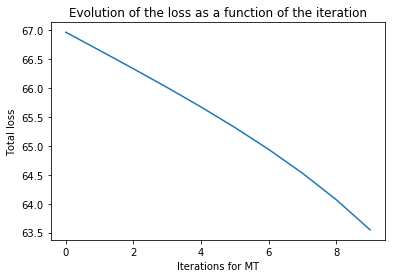

['<SOS>', 'deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'b@@', 'u@@', 'i@@', 's@@', 's@@', 'ons', '.', '<EOS>']
['<SOS>', 'two', 'young', ',', 'white', 'm@@', 'al@@', 'es', 'are', 'outside', 'near', 'many', 'bu@@', 'sh@@', 'es', '.', '<EOS>']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [76]:
epochs = 10
learning_rate = 0.1
w_embedding_dim = 100
p_embedding_dim = 100
dec_embedding_dim = 100
dropout_prob = 0.1

# model_encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length)
# model_decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)
model_NMT = NMTModel(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, vocab_size_en, dropout_prob)

optimizer_NMT = optim.SGD(model_NMT.parameters(), lr = learning_rate)
# optimizer_encoder = optim.SGD(model_encoder.parameters(), lr = learning_rate)
# optimizer_decoder = optim.SGD(model_decoder.parameters(), lr = learning_rate)

loss_func = nn.NLLLoss()
losses = []
avg_losses = []

portion = 10

train = True
print('epoch, total loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for s in range(portion):
     
        current_input = corpus2id_fr[s]
        gold_output = corpus2id_en[s]
        
        if len(current_input) > 0 and len(gold_output) > 0:
            
            optimizer_NMT.zero_grad()
            
            sent_fr = torch.tensor(np.asarray(current_input), dtype= torch.long)
            sent_en = torch.tensor(np.asarray(gold_output), dtype= torch.long)

            pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
            pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))
        
            pred, attention_weights = model_NMT(sent_fr, pos_fr, sent_en, train)
            
            #sent_en = sent_en[1:len(sent_en)] #skip SOS
            loss = loss_func(pred[0], sent_en)
            loss.backward()
            
            optimizer_NMT.step()
            
            total_loss += loss.item() 
       
    now = datetime.now()
        
    losses.append(total_loss)
    
    print(e, total_loss/portion, now-then)

with open('model_NMT' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model_NMT,file)

    
iteration= list(range(len(losses)))

plt.plot(iteration, losses)
plt.xlabel("Iterations for MT")
plt.ylabel('Total loss')
plt.title('Evolution of the loss as a function of the iteration')
plt.savefig("mt" + str(portion)+".png")
plt.show()

test_fr_sentence = corpus2id_fr[0]
test_en_sentence = corpus2id_en[0]
    
decoder_outputs, decoder_attentions = evaluate_sent(model_NMT, test_fr_sentence, test_en_sentence)

print(word_ids2string(test_fr_sentence, id2tokens_fr))
print(word_ids2string(test_en_sentence, id2tokens_en))
print(word_ids2string(decoder_outputs, id2tokens_en))

In [ ]:
pair = 3

test_fr_sentence = corpus2id_fr[pair]
test_en_sentence = corpus2id_en[pair]
    
decoder_outputs, decoder_attentions = evaluate_sent(model_NMT,test_fr_sentence, test_en_sentence)

french_gold = word_ids2string(test_fr_sentence, id2tokens_fr)
print(french_gold)
print(len(word_ids2string(test_fr_sentence, id2tokens_fr)))

english_gold = word_ids2string(test_en_sentence, id2tokens_en)
print(english_gold)

english_output = word_ids2string(decoder_outputs, id2tokens_en)
print(english_output)
print(len(word_ids2string(decoder_outputs, id2tokens_en)))

print(decoder_attentions.size())
S = decoder_attentions
sent_num = pair

# visualize_attention(S,sent_num)

french_gold = (" ").join(french_gold)
showAttention(french_gold,english_output,S,pair)

In [ ]:
with open('model_encoder' + str(portion) + '.pickle','rb') as file:
    model_encoder = pickle.load(file)
      

with open('model_decoder' + str(portion) + '.pickle','rb') as file:
    model_decoder = pickle.load(file)

In [63]:
def evaluate_sent(model_NMT, sent_fr, sent_en):
    
    with torch.no_grad():
        
        sent_fr = torch.tensor(np.asarray(sent_fr), dtype= torch.long)
        sent_en = torch.tensor(np.asarray(sent_en), dtype= torch.long)

        pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
        pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))

#         average_context, stacked_contexts = model_encoder(sent_fr, pos_fr)
        
#         decoder_outputs, decoder_attentions = model_decoder(sent_en, average_context, stacked_contexts, train=False)
        
        decoder_outputs, decoder_attentions = model_NMT(sent_fr, pos_fr, sent_en, train=False)
        
    return decoder_outputs, decoder_attentions

In [64]:
def word_ids2string(sentence, id2token):
    
    converted = []

    for s in sentence:
        converted.append(id2token[s])
        
    return converted

In [65]:
#write the results of the predicted sentences to a txt file for evaluation

def write_test_eval(model_NMT, test_sentences_fr, test_sentences_en):

    filename = "test_results.txt" 
    output = open(filename,"w") 
    
    for sent in range(2): #range(len(test_sentences_fr)):

        decoder_outputs, decoder_attentions = evaluate_sent(model_NMT, test_sentences_fr[sent], test_sentences_en[sent])
        print(decoder_attentions.size())
        
        output_list = word_ids2string(decoder_outputs, id2tokens_en)
        if '<EOS>' in output_list:
            output_list.remove('<EOS>')
        
        output_string = (" ").join(output_list)
        
        output.write(output_string + "\n")

    output.close()
    

In [66]:
write_test_eval(model_NMT, test_corpus2id_fr, test_corpus2id_en)

NameError: name 'test_corpus2id_fr' is not defined

In [67]:
#TODO
#BEAM SEARCH
#teacher forcing prob
#dropout prob
#gru lstm rnn check
#relu before rnn?

In [68]:
def visualize_attention(S,sent_num):
    
    #model_encoder, model_decoder, sent_en, sent_fr
    
    #************************************************************************
    # S is the log softmax version of S, also a torch Tensor! (actually more acurately it's a Variable(Tensor(..))
    #************************************************************************

    S = S.exp()
    
    # Plot the attention tensor
    plt.clf()
    numpy_S = S.data.numpy()
    numpy_S = numpy_S[:,:,0]
    #print(numpy_S.shape)

    plt.imshow(numpy_S)
    imname = "attentions-test-" + str(sent_num)
    plt.savefig(imname)


In [ ]:
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions, sentence_number):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    attentions = attentions.exp()
    cax = ax.matshow(attentions[:,:,0].data.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    imname = "attentions-test-" + str(sentence_number)
    plt.savefig(imname)
    plt.show()
  

In [ ]:
a = torch.tensor(np.asarray([i for i in range(10)]), dtype= torch.float)

In [ ]:
a

In [ ]:
asf = F.log_softmax(a, dim=0)
print(asf)

In [ ]:
a*0.1

In [ ]:
b = torch.tensor(np.asarray([i+1 for i in range(10)]), dtype= torch.float)

In [ ]:
st = torch.stack([a,b], dim = 0)
print(st)

In [ ]:
weights = torch.tensor(np.asarray([0.1, 0.2]), dtype = torch.float).view(-1,1)
print(weights.shape)

torch.mul(weights, st)
# torch.matmul(weights.view(1,2), st)

In [ ]:
torch.stack([a,b], dim = 1)

In [ ]:
torch.mean(st, dim = 1)

In [ ]:
torch.mean(st, dim = 0)

In [ ]:
F.softmax(st, dim = 0)

In [ ]:
a = a*-1

In [ ]:
long(torch.argmax(a))

In [ ]:
test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
print(test_word, test_word.shape)

In [ ]:

#     attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         attn_applied = torch.bmm(attn_weights.unsqueeze(0),
#                                  encoder_outputs.unsqueeze(0))

#         output = torch.cat((embedded[0], attn_applied[0]), 1)
#         output = self.attn_combine(output).unsqueeze(0)
           
#         atts= torch.matmul(es, hidden_from_decoder)
        
#         weighted_context = es*attention_weights
        
        #if EOS for encoder, move on to the decoder
        
        #attention_matrices = self.attention_projection(e_out)
        
        #input embedding
        #set hidden at the beginning
        #get rnn output
        #apply softmax

        #feed actual word for training
        #feed previous word for testing

#             #view_shape = embeddings.shape[0]
#             output, (hidden, cell) = self.bidirLSTM(embeddings.view(1, 1, -1)) 

#             hid_f = hidden[0]
#             hid_b = hidden[1]